In [1]:
%pip install "zenml[server]"
%pip install zenml
!zenml integration install sklearn -y
%pip install pyparsing
import IPython

NumExpr defaulting to 2 threads.
⠧ Installing integrations...


In [21]:
NGROK_TOKEN = "2g1Z76FuOM79vB5oCcSIvV2jeuO_3C314Zh9jEVFnBj5928km"
from zenml.environment import Environment

if Environment.in_google_colab():
  !pip install pyngrok
  !ngrok authtoken {NGROK_TOKEN}

!rm -rf .zen
!zenml init

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
NumExpr defaulting to 2 threads.
⠋ Initializing ZenML repository at /content.
⠙ Initializing ZenML repository at /content.
⠹ Initializing ZenML repository at /content.
⠸ Initializing ZenML repository at /content.
⠼ Initializing ZenML repository at /content.
Setting the repo active workspace to 'default'.
Setting the repo active stack to default.
ZenML repository initialized at /content.
⠼ Initializing ZenML repository at /content.
⠼ Initializing ZenML repository at /content.

The local active stack was initialized to 'default'. This local configuration will only take effect 
when you're running ZenML from the initialized repository root, or from a subdirectory. For more 
information on repositories and configurations, please visit 
https://docs.zenml.io/user-guide/starter-guide/understand-stacks.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from typing import Annotated, Optional, Tuple

from zenml import get_step_context, pipeline, step
from zenml.client import Client

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import tensorflow.keras as keras
from typing import Tuple
from sklearn.model_selection import train_test_split

import logging
import os

import matplotlib.pyplot as plt

from typing import Iterator

In [6]:
directory_path = "/content/drive/MyDrive/PFA_codes/DataSets/CICIDS2017/ProcessedDataset"
data_path = os.path.join(directory_path, "MachineLearningCVE.csv")

In [7]:

@step
def label_encoding_step(data_path: str) -> Annotated[LabelEncoder, "le"]:
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder

    labels = pd.read_csv(data_path, usecols=['Label'], skipinitialspace=True)

    le = LabelEncoder()
    le.fit(labels['Label'])
    return le



def process_data(df: pd.DataFrame, le: LabelEncoder) -> Annotated[pd.DataFrame, "df"]:

    df['Label'] = le.transform(df['Label'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df[df < 0] = np.nan
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df



def split_data(df: pd.DataFrame) -> Tuple[Annotated[pd.DataFrame, "x_train"], Annotated[pd.DataFrame, "x_test"], Annotated[pd.DataFrame, "y_train"], Annotated[pd.DataFrame, "y_test"]]:

    # Sampling the dataset
    x = df.drop(columns=['Label'])
    y = df[['Label']]

    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20, random_state=np.random.randint(10))

    return x_train, x_test, y_train, y_test



@step
def preprocessing_all_step(le: LabelEncoder, data_path: str, chunksize=1000000) -> Tuple[Annotated[pd.DataFrame, "x_train"], Annotated[pd.DataFrame, "x_test"], Annotated[pd.DataFrame, "y_train"], Annotated[pd.DataFrame, "y_test"]]:
    import pandas as pd

    """
    Preprocess all files, handle class representation, split into train and test, and save.

    Args:
        le (LabelEncoder): The label encoder.
        data_path (str): Path to the data file.
        processed_dir_path (str): Directory path to save processed files.
        chunksize (int): Size of chunks to process the data.

    Returns:
        None: Saves processed chunks directly to files.
    """
    for chunk in pd.read_csv(data_path, skipinitialspace=True, chunksize=chunksize):
        # Process the chunk
        processed_chunk = process_data(chunk, le)

        # Check if there is any class with only one instance
        class_counts = processed_chunk['Label'].value_counts()
        classes_with_single_instance = class_counts[class_counts == 1].index.tolist()

        # Add another instance for each class with only one instance
        for cls in classes_with_single_instance:
            single_instance = processed_chunk[processed_chunk['Label'] == cls].iloc[0]
            processed_chunk = pd.concat([processed_chunk, single_instance.to_frame().T], ignore_index=True)

        # Split and save the processed chunk
        x_train, x_test, y_train, y_test = split_data(processed_chunk)

        return x_train, x_test, y_train, y_test



def scale_data(x: np.ndarray) -> Annotated[np.ndarray, "x_scaled"]:
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    return x_scaled



def reshape_data_for_cnn(x: np.ndarray) -> Annotated[np.ndarray, "result"]:
    import numpy as np

    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x
    result = result.reshape((result.shape[0], 9, 9, 1))
    return result



@step
def create_cnn_model_step() -> Annotated[keras.Model, "model"]:
    import tensorflow.keras as keras

    inputs = keras.layers.Input(shape=(9, 9, 1))
    x = keras.layers.Conv2D(120, (2, 2), activation='relu', padding="same")(inputs)
    x = keras.layers.Conv2D(60, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.Conv2D(30, (4, 4), activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
    return model



@step
def train_model_step(model: keras.Model, data_path: str, le: LabelEncoder, chunksize=1000000) -> Annotated[keras.callbacks.History, "history"]:
    import tensorflow.keras as keras

    x_train, x_test, y_train, y_test = preprocessing_all_step(le, data_path)

    x_train = scale_data(x_train)
    x_train = reshape_data_for_cnn(x_train)

    history = model.fit(x_train, y_train, validation_split=0.1, epochs=125, batch_size=1024, verbose=1)
    return history



@step
def plot_training_history_step(history: keras.callbacks.History) -> None:
    import matplotlib.pyplot as plt

    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



@step
def evaluate_model_step(model: keras.Model, data_path: str, le: LabelEncoder, chunksize=1000000) -> None:
    import tensorflow.keras as keras
    from sklearn.metrics import classification_report

    x_train, x_test, y_train, y_test = preprocessing_all_step(le, data_path)

    x_test = scale_data(x_test)
    x_test = reshape_data_for_cnn(x_test)

    score = model.evaluate(x_test, y_test, verbose=1)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    report = classification_report(y_test, y_pred)
    print('Evaluation:\n', report)




In [11]:
from zenml import pipeline

@pipeline
def preprocessing_pipeline():
  le = label_encoding_step(data_path)
  df = preprocessing_all_step(le, data_path, after=["label_encoding_step"])



In [12]:
from zenml import pipeline

@pipeline
def cnn_training_pipeline():
    le = label_encoding_step(data_path)
    model = create_cnn_model_step(after=["label_encoding_step"])
    history = train_model_step(model, data_path, le, after=["create_cnn_model_step", "label_encoding_step"])
    plot_training_history_step(history, after=["train_model_step"])
    evaluate_model_step(model, data_path, le, after=["plot_training_history_step"])



In [13]:
# Configure and run the Preprocessing Pipeline
preprocessing_pipeline = preprocessing_pipeline.with_options(enable_cache=False)
preprocessing_pipeline()


Initiating a new run for the pipeline: preprocessing_pipeline.
Registered new version: (version 2).
Executing a new run.
Caching is disabled by default for preprocessing_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  orchestrator: default
Dashboard URL: http://127.0.0.1:8237/runs/70b94135-3e12-4c51-b88d-b02587a4ba01
Step label_encoding_step has started.
Step label_encoding_step has finished in 9.259s.
Step preprocessing_all_step has started.
Step preprocessing_all_step has finished in 51.380s.
Pipeline run has finished in 1m0s.


PipelineRunResponse(body=PipelineRunResponseBody(created=datetime.datetime(2024, 5, 5, 0, 47, 1, 391049), updated=datetime.datetime(2024, 5, 5, 0, 48, 2, 463066), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 5, 5, 0, 0, 24, 87472), updated=datetime.datetime(2024, 5, 5, 0, 0, 24, 87477), active=True, activation_token=None, full_name='', email_opted_in=None, is_service_account=False, is_admin=True), metadata=None, resources=None, id=UUID('93ce2d77-057e-4a7a-88ca-f0defc269d70'), permission_denied=False, name='default'), status=<ExecutionStatus.COMPLETED: 'completed'>, stack=StackResponse(body=StackResponseBody(created=datetime.datetime(2024, 5, 5, 0, 0, 23, 658631), updated=datetime.datetime(2024, 5, 5, 0, 0, 23, 658634), user=None), metadata=None, resources=None, id=UUID('97f71ef5-a4c1-4e3a-90cc-ef9432bdfb0b'), permission_denied=False, name='default'), pipeline=PipelineResponse(body=PipelineResponseBody(created=datetime.datetime(2024, 5, 5, 0, 47, 0, 751369), u

In [14]:
preprocessing_pipeline = Client().get_pipeline("preprocessing_pipeline")

last_run = preprocessing_pipeline.last_run
x_train = last_run.steps["preprocessing_all_step"].outputs["x_train"].load()
x_test = last_run.steps["preprocessing_all_step"].outputs["x_test"].load()
y_train = last_run.steps["preprocessing_all_step"].outputs["y_train"].load()
y_test = last_run.steps["preprocessing_all_step"].outputs["y_test"].load()



In [15]:
!zenml up

NumExpr defaulting to 2 threads.
The local ZenML server is already configured with the same parameters.
Calling start method...
⠋ Starting service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen_server, flavor: 
local)'.

start method executed successfully.
Connecting ZenML to the 'local' local ZenML server (http://127.0.0.1:8237).
Updated the global store configuration.
Connected ZenML to the 'local' local ZenML server (http://127.0.0.1:8237).
The local ZenML dashboard is available at 'http://127.0.0.1:8237'. You can connect to it using the 
'default' username and an empty password. 


Initiating a new run for the pipeline: cnn_training_pipeline.
Registered new version: (version 2).
Executing a new run.
Caching is disabled by default for cnn_training_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  orchestrator: default
Dashboard URL: http://127.0.0.1:8237/runs/0f852dd9-223a-4eba-85fa-acb38ce542e2
Step label_encoding_step has started.
Step label_encoding_step has finished in 7.590s.
Step create_cnn_model_step has started.
No materializer is registered for type <class 'keras.src.engine.functional.Functional'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'keras.src.engine.functional.Functional'> according to the instructions at https://docs.zenml.io/user-guide/advanced-guide/artifact-management/handle-custom-data-types
Step 

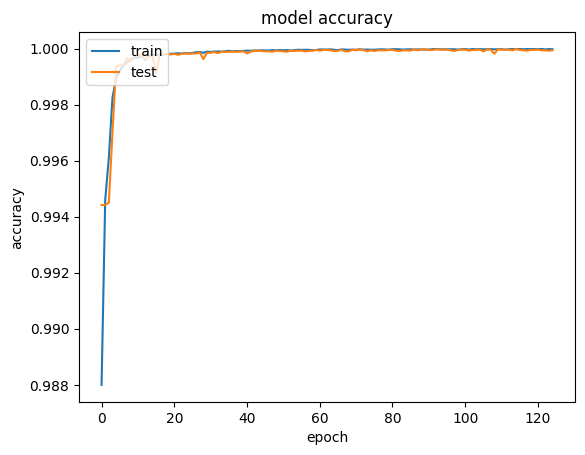

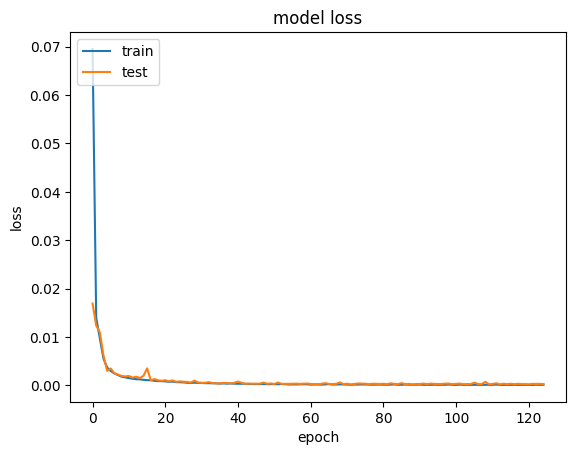

Step plot_training_history_step has finished in 0.804s.
Step evaluate_model_step has started.
Skipping variable loading for optimizer 'Adam', because it has 17 variables whereas the saved optimizer has 1 variables. 
6251/6251 [==============================] - 13s 2ms/step
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-

PipelineRunResponse(body=PipelineRunResponseBody(created=datetime.datetime(2024, 5, 5, 0, 48, 14, 699052), updated=datetime.datetime(2024, 5, 5, 1, 19, 30, 334452), user=UserResponse(body=UserResponseBody(created=datetime.datetime(2024, 5, 5, 0, 0, 24, 87472), updated=datetime.datetime(2024, 5, 5, 0, 0, 24, 87477), active=True, activation_token=None, full_name='', email_opted_in=None, is_service_account=False, is_admin=True), metadata=None, resources=None, id=UUID('93ce2d77-057e-4a7a-88ca-f0defc269d70'), permission_denied=False, name='default'), status=<ExecutionStatus.COMPLETED: 'completed'>, stack=StackResponse(body=StackResponseBody(created=datetime.datetime(2024, 5, 5, 0, 0, 23, 658631), updated=datetime.datetime(2024, 5, 5, 0, 0, 23, 658634), user=None), metadata=None, resources=None, id=UUID('97f71ef5-a4c1-4e3a-90cc-ef9432bdfb0b'), permission_denied=False, name='default'), pipeline=PipelineResponse(body=PipelineResponseBody(created=datetime.datetime(2024, 5, 5, 0, 48, 14, 247541)

In [16]:
# Configure and run the CNN Training Pipeline
cnn_training_pipeline = cnn_training_pipeline.with_options(enable_cache=False)
cnn_training_pipeline()


In [18]:
cnn_training_pipeline = Client().get_pipeline("cnn_training_pipeline")

last_run = cnn_training_pipeline.last_run
cnn_model = last_run.steps["create_cnn_model_step"].outputs["model"].load()


Skipping variable loading for optimizer 'Adam', because it has 17 variables whereas the saved optimizer has 1 variables. 


In [19]:
!zenml down

NumExpr defaulting to 2 threads.
Disconnecting ZenML from the 'local' local ZenML server (http://127.0.0.1:8237).
Disconnected ZenML from the ZenML server.
Tearing down the 'local' local ZenML server.
Removing the local ZenML server.
Calling stop method...
⠋ Stopping service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen_server, flavor: 
local)'.
⠙ Stopping service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen_server, flavor: 
local)'.
⠹ Stopping service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen_server, flavor: 
local)'.
⠸ Stopping service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen_server, flavor: 
local)'.
⠼ Stopping service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen_server, flavor: 
local)'.
⠴ Stopping service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen_server, flavor: 
local)'.
⠦ Stopping service 'LocalZenServer[6323277c-2455-4474-9d98-cad23d28a694] (type: zen

In [22]:
from zenml.environment import Environment

def start_zenml_dashboard(port=8237):
  if Environment.in_google_colab():
    from pyngrok import ngrok

    public_url = ngrok.connect(port)
    #print(f"\xlb[31mIn Colab, use this url instead: {public_url}!\xlb]0m")
    print(f"\x1b[31mIn Colab, use this url instead: {public_url}!\x1b[0m")
    !zenml up --blocking --port {port}

  else:
    !zenml up --port {port}
start_zenml_dashboard()

INFO:pyngrok.ngrok:Opening tunnel named: http-8237-bd3db8f1-8b0d-48ae-be66-2417d530a9a1


Opening tunnel named: http-8237-bd3db8f1-8b0d-48ae-be66-2417d530a9a1


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:18+0000 lvl=info msg="no configuration paths supplied"


t=2024-05-05T01:23:18+0000 lvl=info msg="no configuration paths supplied"


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:18+0000 lvl=info msg="using configuration at default config path" path=/root/.config/ngrok/ngrok.yml


t=2024-05-05T01:23:18+0000 lvl=info msg="using configuration at default config path" path=/root/.config/ngrok/ngrok.yml


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:18+0000 lvl=info msg="open config file" path=/root/.config/ngrok/ngrok.yml err=nil


t=2024-05-05T01:23:18+0000 lvl=info msg="open config file" path=/root/.config/ngrok/ngrok.yml err=nil


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:18+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]


t=2024-05-05T01:23:18+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg="client session established" obj=tunnels.session


t=2024-05-05T01:23:19+0000 lvl=info msg="client session established" obj=tunnels.session


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg="tunnel session started" obj=tunnels.session


t=2024-05-05T01:23:19+0000 lvl=info msg="tunnel session started" obj=tunnels.session


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg=start pg=/api/tunnels id=428fdabfe7d37a9e


t=2024-05-05T01:23:19+0000 lvl=info msg=start pg=/api/tunnels id=428fdabfe7d37a9e


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg=end pg=/api/tunnels id=428fdabfe7d37a9e status=200 dur=336.811µs


t=2024-05-05T01:23:19+0000 lvl=info msg=end pg=/api/tunnels id=428fdabfe7d37a9e status=200 dur=336.811µs


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg=start pg=/api/tunnels id=efecc4281d7a18d2


t=2024-05-05T01:23:19+0000 lvl=info msg=start pg=/api/tunnels id=efecc4281d7a18d2


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg=end pg=/api/tunnels id=efecc4281d7a18d2 status=200 dur=118.697µs


t=2024-05-05T01:23:19+0000 lvl=info msg=end pg=/api/tunnels id=efecc4281d7a18d2 status=200 dur=118.697µs


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg=start pg=/api/tunnels id=6703b4f3aca327f0


t=2024-05-05T01:23:19+0000 lvl=info msg=start pg=/api/tunnels id=6703b4f3aca327f0


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg="started tunnel" obj=tunnels name=http-8237-bd3db8f1-8b0d-48ae-be66-2417d530a9a1 addr=http://localhost:8237 url=https://64dc-35-240-189-252.ngrok-free.app


In Colab, use this url instead: NgrokTunnel: "https://64dc-35-240-189-252.ngrok-free.app" -> "http://localhost:8237"!
t=2024-05-05T01:23:19+0000 lvl=info msg="started tunnel" obj=tunnels name=http-8237-bd3db8f1-8b0d-48ae-be66-2417d530a9a1 addr=http://localhost:8237 url=https://64dc-35-240-189-252.ngrok-free.app


INFO:pyngrok.process.ngrok:t=2024-05-05T01:23:19+0000 lvl=info msg=end pg=/api/tunnels id=6703b4f3aca327f0 status=201 dur=251.925056ms


t=2024-05-05T01:23:19+0000 lvl=info msg=end pg=/api/tunnels id=6703b4f3aca327f0 status=201 dur=251.925056ms
NumExpr defaulting to 2 threads.
The local ZenML dashboard is about to deploy in a blocking process. You can connect to it using the 
'default' username and an empty password.
Deploying a local ZenML server with name 'local'.
Initializing the ZenML global configuration version to 0.57.0
Starting ZenML Server as blocking process... press CTRL+C once to stop it.
INFO:     Started server process [31396]
INFO:     Waiting for application startup.
Not writing the global configuration to disk in a ZenML server environment.
Not writing the global configuration to disk in a ZenML server environment.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8237 (Press CTRL+C to quit)


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=af74f90e2ba5 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=af74f90e2ba5 l=127.0.0.1:8237 r=197.22.215.157:7820
INFO:     197.22.215.157:0 - "GET / HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=3fe78d487ca4 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:     197.22.215.157:0 - "GET /assets/%40tanstack-D1KSn3AD.js HTTP/1.1" 200 OK
t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=3fe78d487ca4 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=e9e8381b71b0 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=e9e8381b71b0 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=b9ca2016ac15 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=b9ca2016ac15 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=e72e33a2b88d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=e72e33a2b88d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=06528c87259e l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:00+0000 lvl=info msg="join connections" obj=join id=06528c87259e l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=a8de769a6af5 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:     197.22.215.157:0 - "GET /assets/%40reactflow-lOPj8ZwY.css HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/%40radix-Mqgm9uyP.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/index-mCzH7qVB.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/%40react-router-t1nY6c48.js HTTP/1.1" 200 OK
t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=a8de769a6af5 l=127.0.0.1:8237 r=197.22.215.157:7820
INFO:     197.22.215.157:0 - "GET /assets/%40reactflow-D76xjDUs.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-cyrillic-ext-400-normal-tyfMZHQw.woff2 HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=84d253febef5 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=84d253febef5 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=fa5e58ee25ca l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=fa5e58ee25ca l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=5ccf832f947c l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=5ccf832f947c l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=4126357ca17a l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=4126357ca17a l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=6293ceee65d5 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=6293ceee65d5 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=781486d8b07d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=781486d8b07d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=f341bbd6c49a l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=f341bbd6c49a l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b96958b02368 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b96958b02368 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=19264af3944a l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=19264af3944a l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c11d0c665f51 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c11d0c665f51 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b95b95df8b6d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b95b95df8b6d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=369f71c226ca l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=369f71c226ca l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8f16041b3297 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8f16041b3297 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=af6e21e8833b l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=af6e21e8833b l=127.0.0.1:8237 r=197.22.215.157:7820
INFO:     197.22.215.157:0 - "GET /assets/inter-latin-400-normal-BT1H-PT_.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/index-DIiwj6Z5.css HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-greek-400-normal-DQXyrmoy.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-cyrillic-400-normal-Df6ckaLK.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-vietnamese-400-normal-Cnt0N5Vm.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-greek-ext-500-normal-2pdUafRD.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-latin-ext-500-normal-B9u8Q_zH.woff2 HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=22939ae9315d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=22939ae9315d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=31eb5c8a9d4f l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=31eb5c8a9d4f l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d6ff2ddd525c l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d6ff2ddd525c l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=765cd30b4e85 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=765cd30b4e85 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=288f10aa01d3 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=288f10aa01d3 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e59b50ffe84e l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e59b50ffe84e l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c73665bc1e6b l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c73665bc1e6b l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=980f2c647ebe l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=980f2c647ebe l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=06882b046032 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=06882b046032 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=85eb7d5d35a7 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=85eb7d5d35a7 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=69390200fc59 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=69390200fc59 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=112f01990d80 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=112f01990d80 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=50456bd0bb6c l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=50456bd0bb6c l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e2b4fb481e5c l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e2b4fb481e5c l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=9272590892f7 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=9272590892f7 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=50984496c5de l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=50984496c5de l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=31b125b17297 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:     197.22.215.157:0 - "GET /assets/inter-cyrillic-600-normal-DDpWG8g5.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-cyrillic-ext-600-normal-DpA2xaRd.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-greek-500-normal-CmOavsDc.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-greek-ext-400-normal-CIdlr5YK.woff2 HTTP/1.1" 200 OK
t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=31b125b17297 l=127.0.0.1:8237 r=197.22.215.157:7820
INFO:     197.22.215.157:0 - "GET /assets/inter-greek-400-normal-DvIPHDQ7.woff HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-cyrillic-500-normal-BRrLR67x.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-cyrillic-500-normal-DskEQOpE.woff HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-greek-600-normal-B-l8Lzzd.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-vietnamese-400-normal-DIOGfGLL.woff

INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=0b3281bb612b l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=0b3281bb612b l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=1221b85570c9 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=1221b85570c9 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=5bdc3c744be7 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=5bdc3c744be7 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=21383c935f5a l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=21383c935f5a l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=304f49203b67 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=304f49203b67 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=9805f9d50e22 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=9805f9d50e22 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c079a954f920 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c079a954f920 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=77d64409397d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=77d64409397d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=72aa8d4ca821 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=72aa8d4ca821 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=ef72abaee37f l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=ef72abaee37f l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=de46ed5c9753 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=de46ed5c9753 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=77ecb56cfc81 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=77ecb56cfc81 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=012ed5fb66f9 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=012ed5fb66f9 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8b93eaf6917f l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8b93eaf6917f l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=f25f5cad72e2 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=f25f5cad72e2 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=93945d130546 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=93945d130546 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=338f6663f4fd l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:     197.22.215.157:0 - "GET /assets/inter-greek-ext-500-normal-Dtavx3qw.woff HTTP/1.1" 200 OK
t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=338f6663f4fd l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=26e06475fc23 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=26e06475fc23 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=13f16c0cfe65 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=13f16c0cfe65 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=0142a28a8c82 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=0142a28a8c82 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=57e1ddc72375 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=57e1ddc72375 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=1e40b44de574 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=1e40b44de574 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=04a83f65d287 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=04a83f65d287 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=20892254c1f5 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=20892254c1f5 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=366b9e3db3b5 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=366b9e3db3b5 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d03c52a5934d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d03c52a5934d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=fad246913531 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=fad246913531 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=6e396c915d4f l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=6e396c915d4f l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=69fec2150c27 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=69fec2150c27 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=f95db375cb61 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=f95db375cb61 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=4fb37dfdba46 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=4fb37dfdba46 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=25830e8c56fa l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=25830e8c56fa l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=ed2aa19e9c5b l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=ed2aa19e9c5b l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=75101a5e59e6 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=75101a5e59e6 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b5fbdbdc8315 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b5fbdbdc8315 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d428b77691f4 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d428b77691f4 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=658b5c9af6e9 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=658b5c9af6e9 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d2b7e85cd1df l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d2b7e85cd1df l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=1cb75871b445 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=1cb75871b445 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e4b671aa9623 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e4b671aa9623 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=888a7bfb6d45 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=888a7bfb6d45 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8bc71a168520 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8bc71a168520 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=9c20bf47184d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=9c20bf47184d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=54503fafc94a l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=54503fafc94a l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=07a5eb40c909 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=07a5eb40c909 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=6cc8fba893a8 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=6cc8fba893a8 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=2303f6752f5c l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=2303f6752f5c l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=3a13419599f1 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=3a13419599f1 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=2040273de50d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=2040273de50d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=19b50b479fd7 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=19b50b479fd7 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=34ee99e2d1fe l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=34ee99e2d1fe l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e90bb417dc78 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e90bb417dc78 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=631e71459f25 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=631e71459f25 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d81205cdd1bc l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d81205cdd1bc l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=441cfb7d203f l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=441cfb7d203f l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=0d64bfd00772 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=0d64bfd00772 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=073de8d3f0cd l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=073de8d3f0cd l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=4a7a8772e7bf l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=4a7a8772e7bf l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=df6062aacf7a l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=df6062aacf7a l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=32743fadd6c4 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=32743fadd6c4 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d9a26035b8f5 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d9a26035b8f5 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e8f1acda07c0 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=e8f1acda07c0 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=27ce48beeeec l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=27ce48beeeec l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b213a9e041e4 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b213a9e041e4 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=98be9f2a9bdc l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=98be9f2a9bdc l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c115bd71d0dc l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=c115bd71d0dc l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b19aed1f2faf l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=b19aed1f2faf l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=be279cc9bf34 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=be279cc9bf34 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=75b79342a843 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=75b79342a843 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=dfd05b1533e6 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=dfd05b1533e6 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=2a4475ca6b55 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=2a4475ca6b55 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=79bf5ddda51d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=79bf5ddda51d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8f0761706330 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=8f0761706330 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d89753acb8ee l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=d89753acb8ee l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=cfcce57e1558 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=cfcce57e1558 l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=92d4aa07c67e l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=92d4aa07c67e l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=00018671458d l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=00018671458d l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=64237fded095 l=127.0.0.1:8237 r=197.22.215.157:7820


t=2024-05-05T01:24:01+0000 lvl=info msg="join connections" obj=join id=64237fded095 l=127.0.0.1:8237 r=197.22.215.157:7820
INFO:     197.22.215.157:0 - "GET /assets/page-CcD4dK88.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/stacks-video-7gfxpAq4.svg HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/secrets-video-OBJ6irhH.svg HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/page-D0cjePVF.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/page-CTPEW6qd.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/page-Bc6vv2xS.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/acp-Di51JyQf.png HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/Commands-fMis_jtl.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/Infobox-KGxvgilj.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/cloud-only-D2aanxkD.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/page-DJKUidz0.js HTTP/1.1" 200 OK
INFO:    

INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:04+0000 lvl=info msg="join connections" obj=join id=7fbc05cdb53a l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:     197.22.215.157:0 - "GET /api/v1/info HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/page-CcWPJqWX.js HTTP/1.1" 200 OK
t=2024-05-05T01:24:04+0000 lvl=info msg="join connections" obj=join id=7fbc05cdb53a l=127.0.0.1:8237 r=197.22.215.157:7820
INFO:     197.22.215.157:0 - "GET /favicon.ico HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:04+0000 lvl=info msg="join connections" obj=join id=8fac84432e9b l=127.0.0.1:8237 r=197.22.215.157:7820


INFO:     197.22.215.157:0 - "GET /assets/login-mutation-Uza7yZRb.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/index.esm-5yOGu3_l.js HTTP/1.1" 200 OK
t=2024-05-05T01:24:04+0000 lvl=info msg="join connections" obj=join id=8fac84432e9b l=127.0.0.1:8237 r=197.22.215.157:7820
INFO:     197.22.215.157:0 - "GET /assets/zod-DWNKqVmj.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-latin-500-normal-kWhwEdDH.woff2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/inter-latin-600-normal-B2Ssfs8e.woff2 HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:27+0000 lvl=info msg="join connections" obj=join id=aa531ba31ab8 l=127.0.0.1:8237 r=197.22.215.157:8046


t=2024-05-05T01:24:27+0000 lvl=info msg="join connections" obj=join id=aa531ba31ab8 l=127.0.0.1:8237 r=197.22.215.157:8046
Authentication error: error retrieving account saifeddine.benzaied@insat.ucar.tn
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/auth.py", line 202, in authenticate_credentials
    user = zen_store().get_auth_user(user_name_or_id)
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 7898, in get_auth_user
    user = self._get_account_schema(
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 8512, in _get_account_schema
    raise KeyError(error_msg)
KeyError: "No user account with the 'saifeddine.benzaied@insat.ucar.tn' name or ID was found"
Authentication error: invalid username or password
API error
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/utils.py", line 447, in decorated
    retu

INFO:pyngrok.process.ngrok:t=2024-05-05T01:24:39+0000 lvl=info msg="join connections" obj=join id=d03011b1636f l=127.0.0.1:8237 r=197.22.215.157:8033


t=2024-05-05T01:24:39+0000 lvl=info msg="join connections" obj=join id=d03011b1636f l=127.0.0.1:8237 r=197.22.215.157:8033
Authentication error: error retrieving account Benzaied Saifeddine
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/auth.py", line 202, in authenticate_credentials
    user = zen_store().get_auth_user(user_name_or_id)
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 7898, in get_auth_user
    user = self._get_account_schema(
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 8512, in _get_account_schema
    raise KeyError(error_msg)
KeyError: "No user account with the 'Benzaied Saifeddine' name or ID was found"
Authentication error: invalid username or password
API error
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/utils.py", line 447, in decorated
    return func(*args, **kwargs)
  F

INFO:pyngrok.process.ngrok:t=2024-05-05T01:25:19+0000 lvl=info msg="join connections" obj=join id=f72a9aa7eeca l=127.0.0.1:8237 r=197.22.215.157:8014


t=2024-05-05T01:25:19+0000 lvl=info msg="join connections" obj=join id=f72a9aa7eeca l=127.0.0.1:8237 r=197.22.215.157:8014
INFO:     197.22.215.157:0 - "GET /api/v1/info HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:25:25+0000 lvl=info msg="join connections" obj=join id=76417237089f l=127.0.0.1:8237 r=197.22.215.157:7635


t=2024-05-05T01:25:25+0000 lvl=info msg="join connections" obj=join id=76417237089f l=127.0.0.1:8237 r=197.22.215.157:7635
Authentication error: error retrieving account saifeddine.benzaied@insat.ucar.tn
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/auth.py", line 202, in authenticate_credentials
    user = zen_store().get_auth_user(user_name_or_id)
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 7898, in get_auth_user
    user = self._get_account_schema(
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 8512, in _get_account_schema
    raise KeyError(error_msg)
KeyError: "No user account with the 'saifeddine.benzaied@insat.ucar.tn' name or ID was found"
Authentication error: invalid username or password
API error
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/utils.py", line 447, in decorated
    retu

INFO:pyngrok.process.ngrok:t=2024-05-05T01:25:40+0000 lvl=info msg="join connections" obj=join id=fbc298d1a1f2 l=127.0.0.1:8237 r=197.22.215.157:7626


t=2024-05-05T01:25:40+0000 lvl=info msg="join connections" obj=join id=fbc298d1a1f2 l=127.0.0.1:8237 r=197.22.215.157:7626
INFO:     197.22.215.157:0 - "GET /api/v1/info HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:26:29+0000 lvl=info msg="join connections" obj=join id=fee1eba88773 l=127.0.0.1:8237 r=197.22.215.157:7896


t=2024-05-05T01:26:29+0000 lvl=info msg="join connections" obj=join id=fee1eba88773 l=127.0.0.1:8237 r=197.22.215.157:7896
INFO:     197.22.215.157:0 - "GET /api/v1/info HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:26:53+0000 lvl=info msg="join connections" obj=join id=ac8dbbc77470 l=127.0.0.1:8237 r=197.22.215.157:7699


t=2024-05-05T01:26:53+0000 lvl=info msg="join connections" obj=join id=ac8dbbc77470 l=127.0.0.1:8237 r=197.22.215.157:7699
Authentication error: error retrieving account Benzaied Saifeddine
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/auth.py", line 202, in authenticate_credentials
    user = zen_store().get_auth_user(user_name_or_id)
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 7898, in get_auth_user
    user = self._get_account_schema(
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_stores/sql_zen_store.py", line 8512, in _get_account_schema
    raise KeyError(error_msg)
KeyError: "No user account with the 'Benzaied Saifeddine' name or ID was found"
Authentication error: invalid username or password
API error
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/zenml/zen_server/utils.py", line 447, in decorated
    return func(*args, **kwargs)
  F

INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:28+0000 lvl=info msg="join connections" obj=join id=ed6fb11f28b8 l=127.0.0.1:8237 r=197.22.215.157:7642


t=2024-05-05T01:28:28+0000 lvl=info msg="join connections" obj=join id=ed6fb11f28b8 l=127.0.0.1:8237 r=197.22.215.157:7642
INFO:     197.22.215.157:0 - "GET /api/v1/info HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:41+0000 lvl=info msg="join connections" obj=join id=cbc81dd1e759 l=127.0.0.1:8237 r=197.22.215.157:7677


t=2024-05-05T01:28:41+0000 lvl=info msg="join connections" obj=join id=cbc81dd1e759 l=127.0.0.1:8237 r=197.22.215.157:7677
INFO:     197.22.215.157:0 - "POST /api/v1/login HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:41+0000 lvl=info msg="join connections" obj=join id=5773f831131f l=127.0.0.1:8237 r=197.22.215.157:7677


Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/current-user HTTP/1.1" 200 OK
t=2024-05-05T01:28:41+0000 lvl=info msg="join connections" obj=join id=5773f831131f l=127.0.0.1:8237 r=197.22.215.157:7677
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/settings HTTP/1.1" 200 OK
Got token from cookie
INFO:     197.22.215.157:0 - "GET /assets/page-Bc6vv2xS.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /api/v1/current-user HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:42+0000 lvl=info msg="join connections" obj=join id=86cca122f490 l=127.0.0.1:8237 r=197.22.215.157:7677


INFO:     197.22.215.157:0 - "GET /assets/AwarenessChannel-Dfkaig3j.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/SuccessStep-DLO9gQe8.js HTTP/1.1" 200 OK
t=2024-05-05T01:28:42+0000 lvl=info msg="join connections" obj=join id=86cca122f490 l=127.0.0.1:8237 r=197.22.215.157:7677


INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:42+0000 lvl=info msg="join connections" obj=join id=e4379428e4df l=127.0.0.1:8237 r=197.22.215.157:7677


t=2024-05-05T01:28:42+0000 lvl=info msg="join connections" obj=join id=e4379428e4df l=127.0.0.1:8237 r=197.22.215.157:7677


INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:43+0000 lvl=info msg="join connections" obj=join id=4c8ab4224001 l=127.0.0.1:8237 r=197.22.215.157:7677


INFO:     197.22.215.157:0 - "GET /assets/UpdatePasswordSchemas-DWVN5Ejn.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/update-current-user-mutation-BkdKNriO.js HTTP/1.1" 200 OK
t=2024-05-05T01:28:43+0000 lvl=info msg="join connections" obj=join id=4c8ab4224001 l=127.0.0.1:8237 r=197.22.215.157:7677


INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:43+0000 lvl=info msg="join connections" obj=join id=04cc545e3189 l=127.0.0.1:8237 r=197.22.215.157:7677


t=2024-05-05T01:28:43+0000 lvl=info msg="join connections" obj=join id=04cc545e3189 l=127.0.0.1:8237 r=197.22.215.157:7677


INFO:pyngrok.process.ngrok:t=2024-05-05T01:28:43+0000 lvl=info msg="join connections" obj=join id=db42d18ebcd0 l=127.0.0.1:8237 r=197.22.215.157:7677


t=2024-05-05T01:28:43+0000 lvl=info msg="join connections" obj=join id=db42d18ebcd0 l=127.0.0.1:8237 r=197.22.215.157:7677
INFO:     197.22.215.157:0 - "GET /assets/check-circle-B_YRDK8p.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/play-circle-CiCT1iFt.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/file-text-C_aOBzo7.js HTTP/1.1" 200 OK
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/current-user HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:47+0000 lvl=info msg="join connections" obj=join id=939397be08c2 l=127.0.0.1:8237 r=197.22.215.157:7937


t=2024-05-05T01:29:47+0000 lvl=info msg="join connections" obj=join id=939397be08c2 l=127.0.0.1:8237 r=197.22.215.157:7937
Got token from cookie
INFO:     197.22.215.157:0 - "PUT /api/v1/current-user HTTP/1.1" 200 OK
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/current-user HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/CodeSnippet-Bbx6fIb6.css HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/page-BWG2W5if.js HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:51+0000 lvl=info msg="join connections" obj=join id=dcd9411af128 l=127.0.0.1:8237 r=197.22.215.157:7937


INFO:     197.22.215.157:0 - "GET /assets/CodeSnippet-BRHUya0e.js HTTP/1.1" 200 OK
t=2024-05-05T01:29:51+0000 lvl=info msg="join connections" obj=join id=dcd9411af128 l=127.0.0.1:8237 r=197.22.215.157:7937
INFO:     197.22.215.157:0 - "GET /assets/copy-Vxjjuv3p.js HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:52+0000 lvl=info msg="join connections" obj=join id=d8ddd1b3a2f1 l=127.0.0.1:8237 r=197.22.215.157:7937


Got token from cookie
t=2024-05-05T01:29:52+0000 lvl=info msg="join connections" obj=join id=d8ddd1b3a2f1 l=127.0.0.1:8237 r=197.22.215.157:7937


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:52+0000 lvl=info msg="join connections" obj=join id=5199e4822382 l=127.0.0.1:8237 r=197.22.215.157:7937


Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/current-user HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /api/v1/settings HTTP/1.1" 200 OK
t=2024-05-05T01:29:52+0000 lvl=info msg="join connections" obj=join id=5199e4822382 l=127.0.0.1:8237 r=197.22.215.157:7937
INFO:     197.22.215.157:0 - "GET /api/v1/info HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/cloud-squares-DeRLMopf.svg HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:58+0000 lvl=info msg="join connections" obj=join id=47a641d7bf05 l=127.0.0.1:8237 r=197.22.215.157:7874


t=2024-05-05T01:29:58+0000 lvl=info msg="join connections" obj=join id=47a641d7bf05 l=127.0.0.1:8237 r=197.22.215.157:7874
INFO:     197.22.215.157:0 - "GET /assets/page-A44mQhzW.js HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=4005e33980d5 l=127.0.0.1:8237 r=197.22.215.157:7874


INFO:     197.22.215.157:0 - "GET /assets/Cards-DKtc8Mmj.js HTTP/1.1" 200 OK
t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=4005e33980d5 l=127.0.0.1:8237 r=197.22.215.157:7874


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=1f60b79c0434 l=127.0.0.1:8237 r=197.22.215.157:7874


t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=1f60b79c0434 l=127.0.0.1:8237 r=197.22.215.157:7874


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=e38f357049a2 l=127.0.0.1:8237 r=197.22.215.157:7874


t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=e38f357049a2 l=127.0.0.1:8237 r=197.22.215.157:7874


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=6f9b2664b70f l=127.0.0.1:8237 r=197.22.215.157:7874


t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=6f9b2664b70f l=127.0.0.1:8237 r=197.22.215.157:7874


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=13440c0d4dae l=127.0.0.1:8237 r=197.22.215.157:7874


t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=13440c0d4dae l=127.0.0.1:8237 r=197.22.215.157:7874


INFO:pyngrok.process.ngrok:t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=d9f610b8d170 l=127.0.0.1:8237 r=197.22.215.157:7874


t=2024-05-05T01:29:59+0000 lvl=info msg="join connections" obj=join id=d9f610b8d170 l=127.0.0.1:8237 r=197.22.215.157:7874
INFO:     197.22.215.157:0 - "GET /assets/help-CRVM-AXC.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/aws-BZyTWiD0.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/update-server-settings-mutation-BY63tiSL.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/terminal-C3Pq8EZ0.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/Helpbox-BhFBV69t.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/chevron-down-C2EydjPn.js HTTP/1.1" 200 OK
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/info HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /api/v1/settings HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:10+0000 lvl=info msg="join connections" obj=join id=4d546de29e8a l=127.0.0.1:8237 r=197.22.215.157:7699


t=2024-05-05T01:30:10+0000 lvl=info msg="join connections" obj=join id=4d546de29e8a l=127.0.0.1:8237 r=197.22.215.157:7699
INFO:     197.22.215.157:0 - "GET /assets/page-CcD4dK88.js HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:10+0000 lvl=info msg="join connections" obj=join id=46052dcfadfe l=127.0.0.1:8237 r=197.22.215.157:7699


INFO:     197.22.215.157:0 - "GET /assets/refresh-Cx_kzUlu.js HTTP/1.1" 200 OK
t=2024-05-05T01:30:10+0000 lvl=info msg="join connections" obj=join id=46052dcfadfe l=127.0.0.1:8237 r=197.22.215.157:7699


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=550bbf12c717 l=127.0.0.1:8237 r=197.22.215.157:7699


INFO:     197.22.215.157:0 - "GET /assets/Pagination-CPcjsbC9.js HTTP/1.1" 200 OK
t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=550bbf12c717 l=127.0.0.1:8237 r=197.22.215.157:7699


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=30a7fb0142ff l=127.0.0.1:8237 r=197.22.215.157:7699


t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=30a7fb0142ff l=127.0.0.1:8237 r=197.22.215.157:7699


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=60c666dd504d l=127.0.0.1:8237 r=197.22.215.157:7699


t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=60c666dd504d l=127.0.0.1:8237 r=197.22.215.157:7699


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=0722e270bdfe l=127.0.0.1:8237 r=197.22.215.157:7699


INFO:     197.22.215.157:0 - "GET /assets/url-BxOqGmlk.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/PageHeader-BjHR4E5t.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/CopyButton-Dr9DC1Vz.js HTTP/1.1" 200 OK
t=2024-05-05T01:30:11+0000 lvl=info msg="join connections" obj=join id=0722e270bdfe l=127.0.0.1:8237 r=197.22.215.157:7699
INFO:     197.22.215.157:0 - "GET /assets/chevron-right-double-BdbmNpRk.js HTTP/1.1" 200 OK
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/pipeline_namespaces?page=1&sort_by=desc%3Aupdated HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:15+0000 lvl=info msg="join connections" obj=join id=16e5b98e5e9f l=127.0.0.1:8237 r=197.22.215.157:7910


t=2024-05-05T01:30:15+0000 lvl=info msg="join connections" obj=join id=16e5b98e5e9f l=127.0.0.1:8237 r=197.22.215.157:7910
INFO:     197.22.215.157:0 - "GET /assets/page-lSGgLwNT.js HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:16+0000 lvl=info msg="join connections" obj=join id=80b9e67a60e9 l=127.0.0.1:8237 r=197.22.215.157:7910


INFO:     197.22.215.157:0 - "GET /assets/DisplayDate-xz7bjv92.js HTTP/1.1" 200 OK
t=2024-05-05T01:30:16+0000 lvl=info msg="join connections" obj=join id=80b9e67a60e9 l=127.0.0.1:8237 r=197.22.215.157:7910
INFO:     197.22.215.157:0 - "GET /assets/InlineAvatar-CkUo9uYr.js HTTP/1.1" 200 OK
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/runs?pipeline_name=cnn_training_pipeline&page=1&sort_by=desc%3Aupdated HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:26+0000 lvl=info msg="join connections" obj=join id=7bffb56ea3b1 l=127.0.0.1:8237 r=197.22.215.157:7782


t=2024-05-05T01:30:26+0000 lvl=info msg="join connections" obj=join id=7bffb56ea3b1 l=127.0.0.1:8237 r=197.22.215.157:7782
INFO:     197.22.215.157:0 - "GET /assets/page-Do3x195U.js HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:27+0000 lvl=info msg="join connections" obj=join id=c1188386ca6d l=127.0.0.1:8237 r=197.22.215.157:7782


INFO:     197.22.215.157:0 - "GET /assets/database-Dj4E8VCy.js HTTP/1.1" 200 OK
t=2024-05-05T01:30:27+0000 lvl=info msg="join connections" obj=join id=c1188386ca6d l=127.0.0.1:8237 r=197.22.215.157:7782


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:27+0000 lvl=info msg="join connections" obj=join id=77b856199779 l=127.0.0.1:8237 r=197.22.215.157:7782


t=2024-05-05T01:30:27+0000 lvl=info msg="join connections" obj=join id=77b856199779 l=127.0.0.1:8237 r=197.22.215.157:7782


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:27+0000 lvl=info msg="join connections" obj=join id=a4184a18e0bc l=127.0.0.1:8237 r=197.22.215.157:7782


t=2024-05-05T01:30:27+0000 lvl=info msg="join connections" obj=join id=a4184a18e0bc l=127.0.0.1:8237 r=197.22.215.157:7782
INFO:     197.22.215.157:0 - "GET /assets/Error-CEUGb4yn.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/EmptyState-PtKve-r-.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/Infobox-KGxvgilj.js HTTP/1.1" 200 OK
Got token from cookie
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/runs/0f852dd9-223a-4eba-85fa-acb38ce542e2 HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /api/v1/runs/0f852dd9-223a-4eba-85fa-acb38ce542e2/graph HTTP/1.1" 200 OK
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/stacks/97f71ef5-a4c1-4e3a-90cc-ef9432bdfb0b HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:45+0000 lvl=info msg="join connections" obj=join id=a1874cf47299 l=127.0.0.1:8237 r=197.22.215.157:7877


t=2024-05-05T01:30:45+0000 lvl=info msg="join connections" obj=join id=a1874cf47299 l=127.0.0.1:8237 r=197.22.215.157:7877
Got token from cookie
INFO:     197.22.215.157:0 - "GET /api/v1/runs/0f852dd9-223a-4eba-85fa-acb38ce542e2 HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:30:52+0000 lvl=info msg="join connections" obj=join id=eaa21b3c75ce l=127.0.0.1:8237 r=197.22.215.157:7877


t=2024-05-05T01:30:52+0000 lvl=info msg="join connections" obj=join id=eaa21b3c75ce l=127.0.0.1:8237 r=197.22.215.157:7877
INFO:     197.22.215.157:0 - "GET /assets/page-BffaRWF9.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/cloud-only-D2aanxkD.js HTTP/1.1" 200 OK
INFO:     197.22.215.157:0 - "GET /assets/mcp-ocoXuQwQ.png HTTP/1.1" 200 OK


INFO:pyngrok.process.ngrok:t=2024-05-05T01:32:25+0000 lvl=info msg="received stop request" obj=app stopReq="{err:<nil> restart:false}"


t=2024-05-05T01:32:25+0000 lvl=info msg="received stop request" obj=app stopReq="{err:<nil> restart:false}"


INFO:pyngrok.process.ngrok:t=2024-05-05T01:32:25+0000 lvl=info msg="session closing" obj=tunnels.session err=nil


t=2024-05-05T01:32:25+0000 lvl=info msg="session closing" obj=tunnels.session err=nil
INFO:     Shutting down
INFO:     Finished server process [31396]
ERROR:    Traceback (most recent call last):
  File "/usr/lib/python3.10/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "uvloop/loop.pyx", line 1511, in uvloop.loop.Loop.run_until_complete
  File "uvloop/loop.pyx", line 1504, in uvloop.loop.Loop.run_until_complete
  File "uvloop/loop.pyx", line 1377, in uvloop.loop.Loop.run_forever
  File "uvloop/loop.pyx", line 555, in uvloop.loop.Loop._run
  File "uvloop/loop.pyx", line 474, in uvloop.loop.Loop._on_idle
  File "uvloop/cbhandles.pyx", line 83, in uvloop.loop.Handle._run
  File "uvloop/cbhandles.pyx", line 63, in uvloop.loop.Handle._run
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/server.py", line 68, in serve
    with self.capture_signals():
  File "/usr/lib/python3.10/contextlib.py", line 142, in __exit__
    next(self.gen)
  File "/usr